# Phase Differences in IQ Data

This notebook analyzes and visualizes phase differences between channels in the IQ data.
Phase differences are crucial for DOA estimation as they encode the spatial information about signal arrival direction.

## 1. Setup and Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import os

# Import shared constants
from constants import CHANNEL_ORDER, RADIUS, FREQ, WAVELENGTH, DATA_DIR

# Plot settings
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

print("Setup complete!")
print(f"Using channel order: {CHANNEL_ORDER}")

## 2. Data Loading Functions

In [ ]:
def load_cs16(filepath):
    """Load a .cs16 file and return complex IQ samples."""
    raw = np.fromfile(filepath, dtype=np.int16)
    # Interleaved I, Q -> complex
    iq = raw[0::2] + 1j * raw[1::2]
    return iq

def load_measurement(base_dir, angle, channel_order=None):
    """Load all 4 channels for a given angle measurement.
    
    Args:
        base_dir: Base data directory
        angle: Measurement angle in degrees
        channel_order: List specifying channel reordering [ch_for_elem0, ch_for_elem1, ...]
                      If None, uses CHANNEL_ORDER from constants
    """
    if channel_order is None:
        channel_order = CHANNEL_ORDER
    
    data_dir = os.path.join(base_dir, f"{angle}deg")
    channels = []
    for i in range(4):
        filepath = os.path.join(data_dir, f"channel-{i}.cs16")
        channels.append(load_cs16(filepath))
    
    raw_data = np.vstack(channels)  # Shape: (4, num_samples)
    
    # Apply channel reordering
    return raw_data[channel_order]

# Data directory (from constants.py)
DATA_PATH = f"../data/{DATA_DIR}"

# Test loading with correct channel order
X = load_measurement(DATA_PATH, 45)
print(f"Loaded data shape: {X.shape}")
print(f"Samples per channel: {X.shape[1]:,}")
print(f"Channel order: {CHANNEL_ORDER}")

## 3. Raw IQ Phase Visualization

Let's first look at the raw phase of each channel over time.

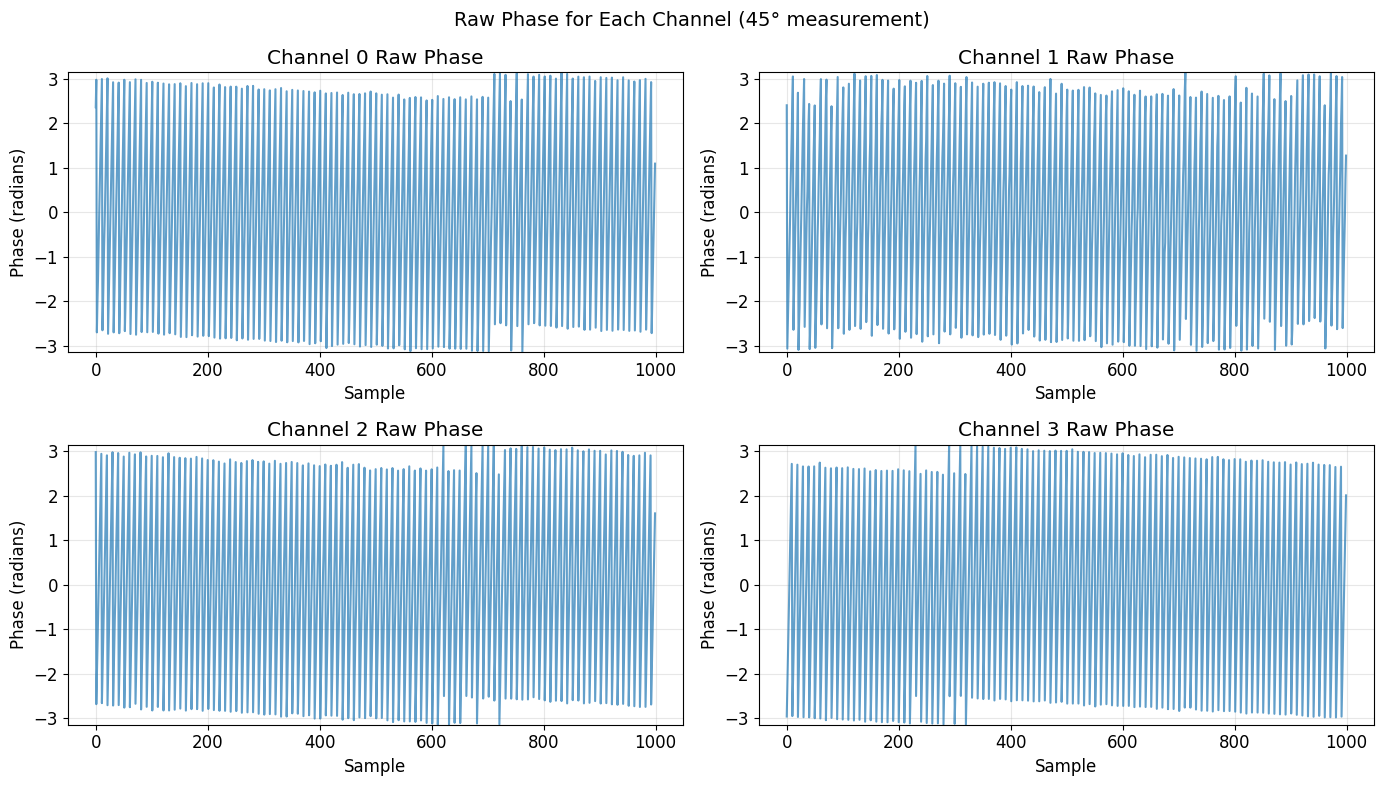

In [3]:
# Extract a segment of samples for visualization
N_SAMPLES = 1000
segment = X[:, :N_SAMPLES]

# Compute phase for each channel
phases = np.angle(segment)  # Shape: (4, N_SAMPLES)

# Plot raw phases
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i in range(4):
    ax = axes[i]
    ax.plot(phases[i], alpha=0.7)
    ax.set_xlabel('Sample')
    ax.set_ylabel('Phase (radians)')
    ax.set_title(f'Channel {i} Raw Phase')
    ax.set_ylim(-np.pi, np.pi)
    ax.grid(True, alpha=0.3)

plt.suptitle('Raw Phase for Each Channel (45° measurement)', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Phase Differences Between Channels

The phase differences between adjacent antennas contain the DOA information.

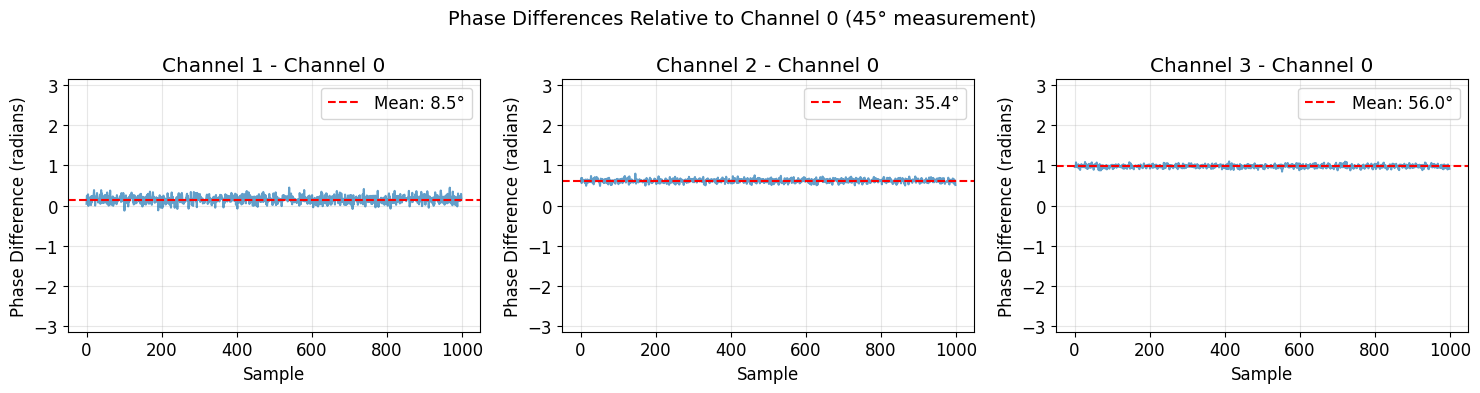

In [4]:
def compute_phase_differences(X, ref_channel=0):
    """
    Compute phase differences relative to a reference channel.
    Returns phase differences in radians, wrapped to [-pi, pi].
    """
    phases = np.angle(X)
    phase_diffs = phases - phases[ref_channel]
    # Wrap to [-pi, pi]
    phase_diffs = np.angle(np.exp(1j * phase_diffs))
    return phase_diffs

# Compute phase differences relative to channel 0
phase_diffs = compute_phase_differences(segment, ref_channel=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, ax in enumerate(axes):
    ch = i + 1  # Channels 1, 2, 3 relative to channel 0
    ax.plot(phase_diffs[ch], alpha=0.7)
    ax.axhline(np.mean(phase_diffs[ch]), color='r', linestyle='--', 
               label=f'Mean: {np.rad2deg(np.mean(phase_diffs[ch])):.1f}°')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Phase Difference (radians)')
    ax.set_title(f'Channel {ch} - Channel 0')
    ax.set_ylim(-np.pi, np.pi)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Phase Differences Relative to Channel 0 (45° measurement)', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Phase Differences at the Signal Tone

For narrowband signals, we should look at the phase at the tone frequency specifically.

In [5]:
def find_tone_bin(X, fft_size=8192):
    """Find the FFT bin with the strongest tone."""
    fft_result = fft(X[0, :fft_size])
    magnitudes = np.abs(fft_result[:fft_size//2])
    tone_bin = np.argmax(magnitudes[1:]) + 1  # Exclude DC
    return tone_bin

def extract_tone_phases(X, fft_size=8192, n_snapshots=100):
    """
    Extract phases at the tone frequency using short-time FFT.
    Returns phases for each channel at each snapshot.
    """
    tone_bin = find_tone_bin(X, fft_size)
    
    n_channels, n_samples = X.shape
    hop = fft_size // 2
    
    phases = []
    for start in range(0, n_samples - fft_size, hop):
        if len(phases) >= n_snapshots:
            break
        segment = X[:, start:start + fft_size]
        fft_seg = fft(segment, axis=1)
        phase = np.angle(fft_seg[:, tone_bin])
        phases.append(phase)
    
    return np.array(phases).T, tone_bin  # Shape: (n_channels, n_snapshots)

# Extract tone phases
tone_phases, tone_bin = extract_tone_phases(X, n_snapshots=200)
print(f"Tone bin: {tone_bin}")
print(f"Tone phases shape: {tone_phases.shape}")

Tone bin: 818
Tone phases shape: (4, 200)


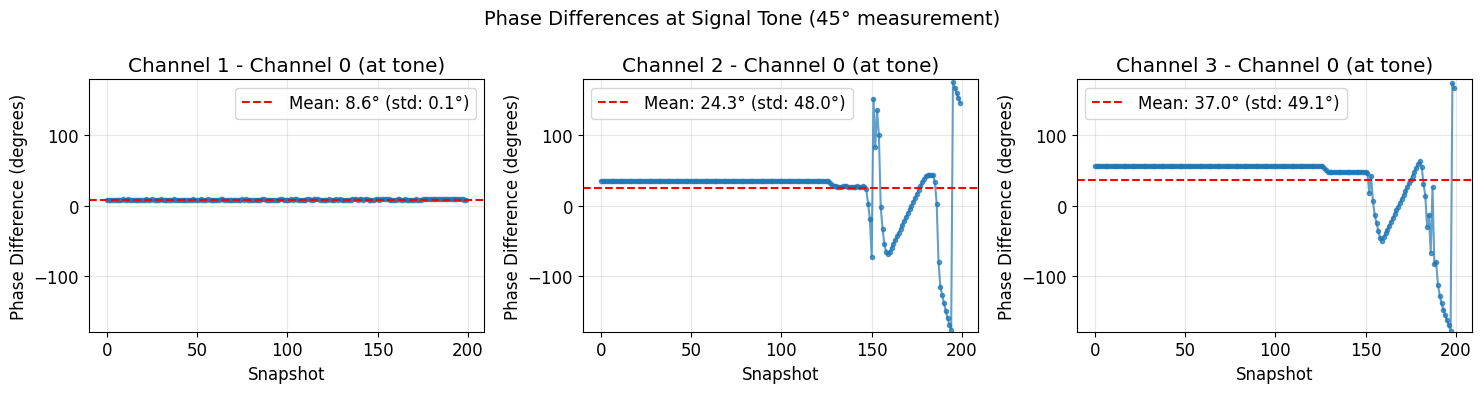

In [6]:
# Compute phase differences at the tone frequency
tone_phase_diffs = tone_phases - tone_phases[0]  # Relative to channel 0
tone_phase_diffs = np.angle(np.exp(1j * tone_phase_diffs))  # Wrap

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, ax in enumerate(axes):
    ch = i + 1
    ax.plot(np.rad2deg(tone_phase_diffs[ch]), 'o-', markersize=3, alpha=0.7)
    mean_deg = np.rad2deg(np.mean(tone_phase_diffs[ch]))
    std_deg = np.rad2deg(np.std(tone_phase_diffs[ch]))
    ax.axhline(mean_deg, color='r', linestyle='--', 
               label=f'Mean: {mean_deg:.1f}° (std: {std_deg:.1f}°)')
    ax.set_xlabel('Snapshot')
    ax.set_ylabel('Phase Difference (degrees)')
    ax.set_title(f'Channel {ch} - Channel 0 (at tone)')
    ax.set_ylim(-180, 180)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Phase Differences at Signal Tone (45° measurement)', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Phase Difference Distribution (Histogram)

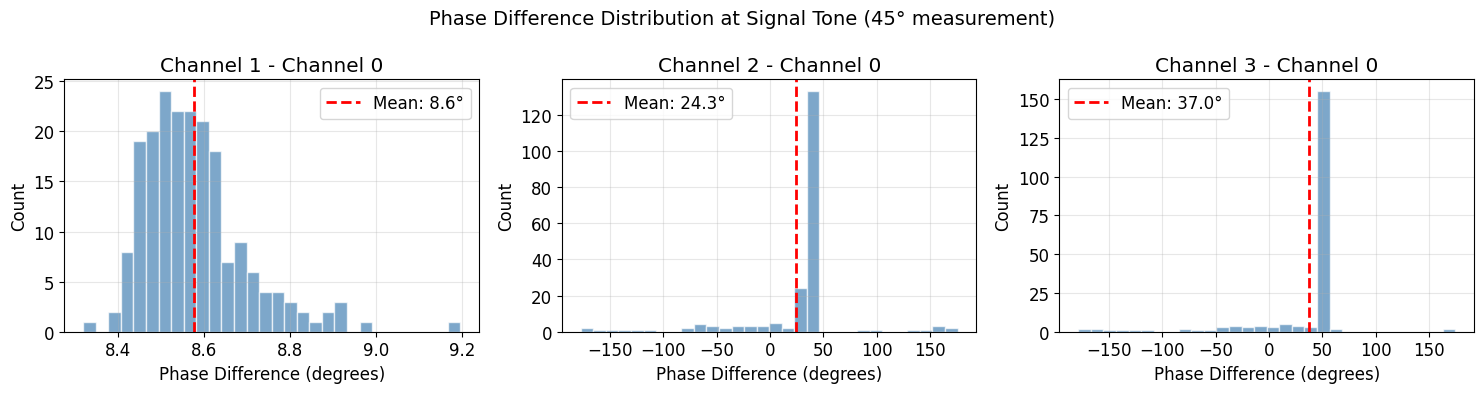

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, ax in enumerate(axes):
    ch = i + 1
    data = np.rad2deg(tone_phase_diffs[ch])
    ax.hist(data, bins=30, edgecolor='white', alpha=0.7, color='steelblue')
    ax.axvline(np.mean(data), color='r', linestyle='--', linewidth=2,
               label=f'Mean: {np.mean(data):.1f}°')
    ax.set_xlabel('Phase Difference (degrees)')
    ax.set_ylabel('Count')
    ax.set_title(f'Channel {ch} - Channel 0')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Phase Difference Distribution at Signal Tone (45° measurement)', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Phase Differences vs True Angle

Let's see how phase differences change with the true DOA angle.

In [ ]:
# Analyze phase differences for multiple angles
test_angles = list(range(0, 360, 15))  # Every 15 degrees

phase_diff_vs_angle = {ch: [] for ch in range(1, 4)}
valid_angles = []

for angle in test_angles:
    try:
        X_angle = load_measurement(DATA_PATH, angle)
        phases, _ = extract_tone_phases(X_angle, n_snapshots=100)
        
        for ch in range(1, 4):
            diff = phases[ch] - phases[0]
            diff = np.angle(np.exp(1j * diff))  # Wrap
            phase_diff_vs_angle[ch].append(np.rad2deg(np.mean(diff)))
        
        valid_angles.append(angle)
    except Exception as e:
        print(f"Error loading {angle}°: {e}")

print(f"Loaded {len(valid_angles)} angles successfully")

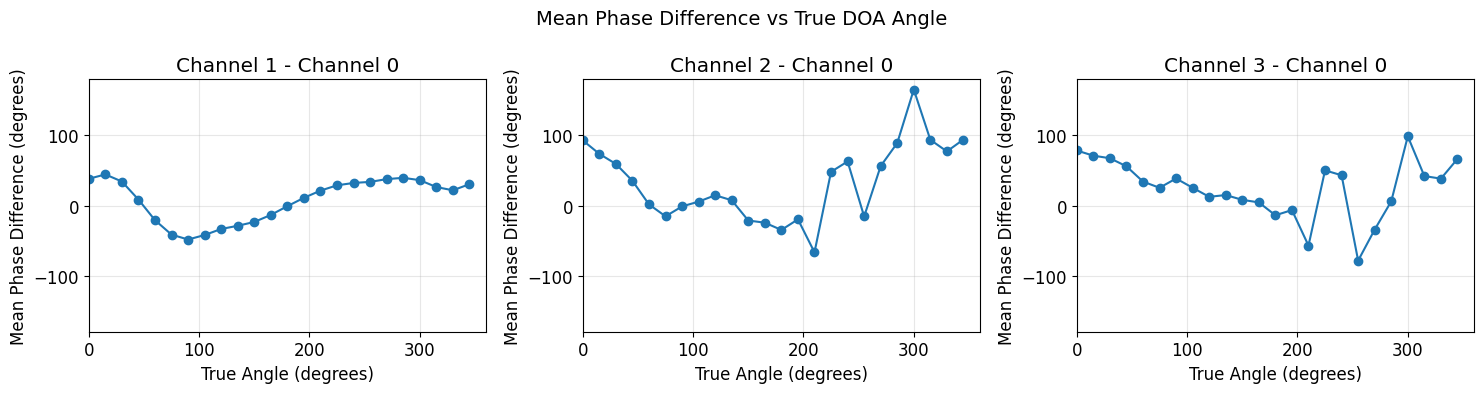

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, ax in enumerate(axes):
    ch = i + 1
    ax.plot(valid_angles, phase_diff_vs_angle[ch], 'o-', markersize=6)
    ax.set_xlabel('True Angle (degrees)')
    ax.set_ylabel('Mean Phase Difference (degrees)')
    ax.set_title(f'Channel {ch} - Channel 0')
    ax.set_xlim(0, 360)
    ax.set_ylim(-180, 180)
    ax.grid(True, alpha=0.3)

plt.suptitle('Mean Phase Difference vs True DOA Angle', fontsize=14)
plt.tight_layout()
plt.show()

## 8. Polar Phase Difference Plot

Visualize phase differences in polar coordinates.

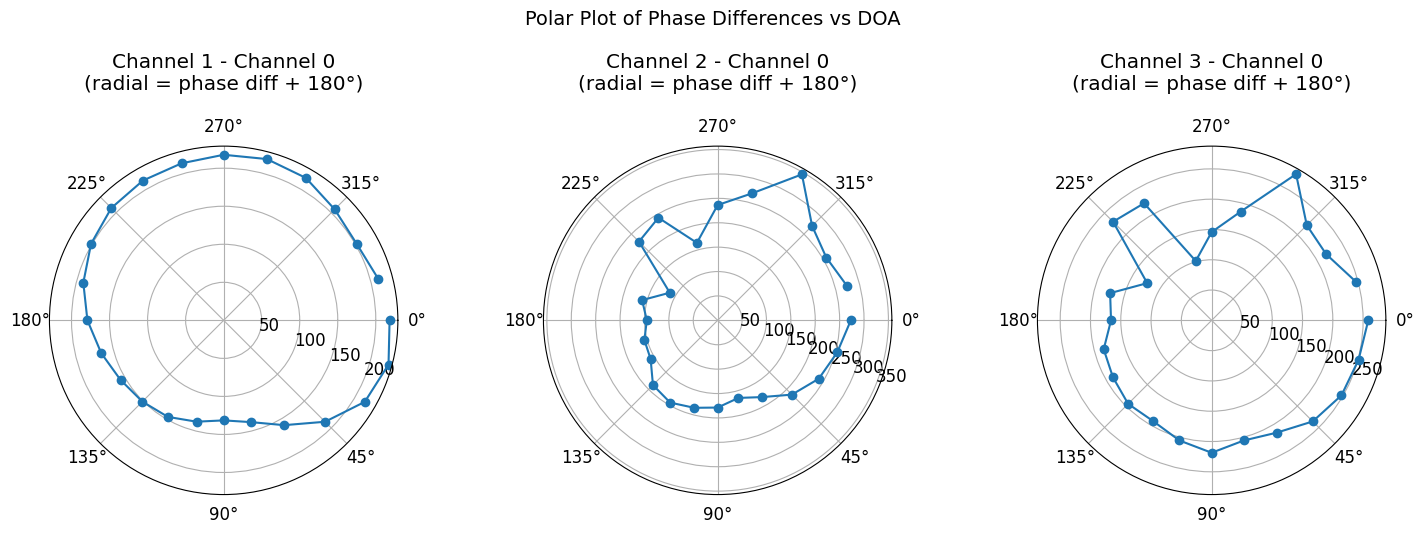

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': 'polar'})

for i, ax in enumerate(axes):
    ch = i + 1
    angles_rad = np.deg2rad(valid_angles)
    phase_diffs_deg = np.array(phase_diff_vs_angle[ch])
    
    # Use phase difference as the radial coordinate (shifted to be positive)
    r = phase_diffs_deg + 180  # Shift to [0, 360]
    
    ax.plot(angles_rad, r, 'o-', markersize=6)
    ax.set_title(f'Channel {ch} - Channel 0\n(radial = phase diff + 180°)', pad=20)
    ax.set_theta_zero_location('E')  # 0° at East
    ax.set_theta_direction(-1)  # Clockwise

plt.suptitle('Polar Plot of Phase Differences vs DOA', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 9. All Channel Pair Phase Differences

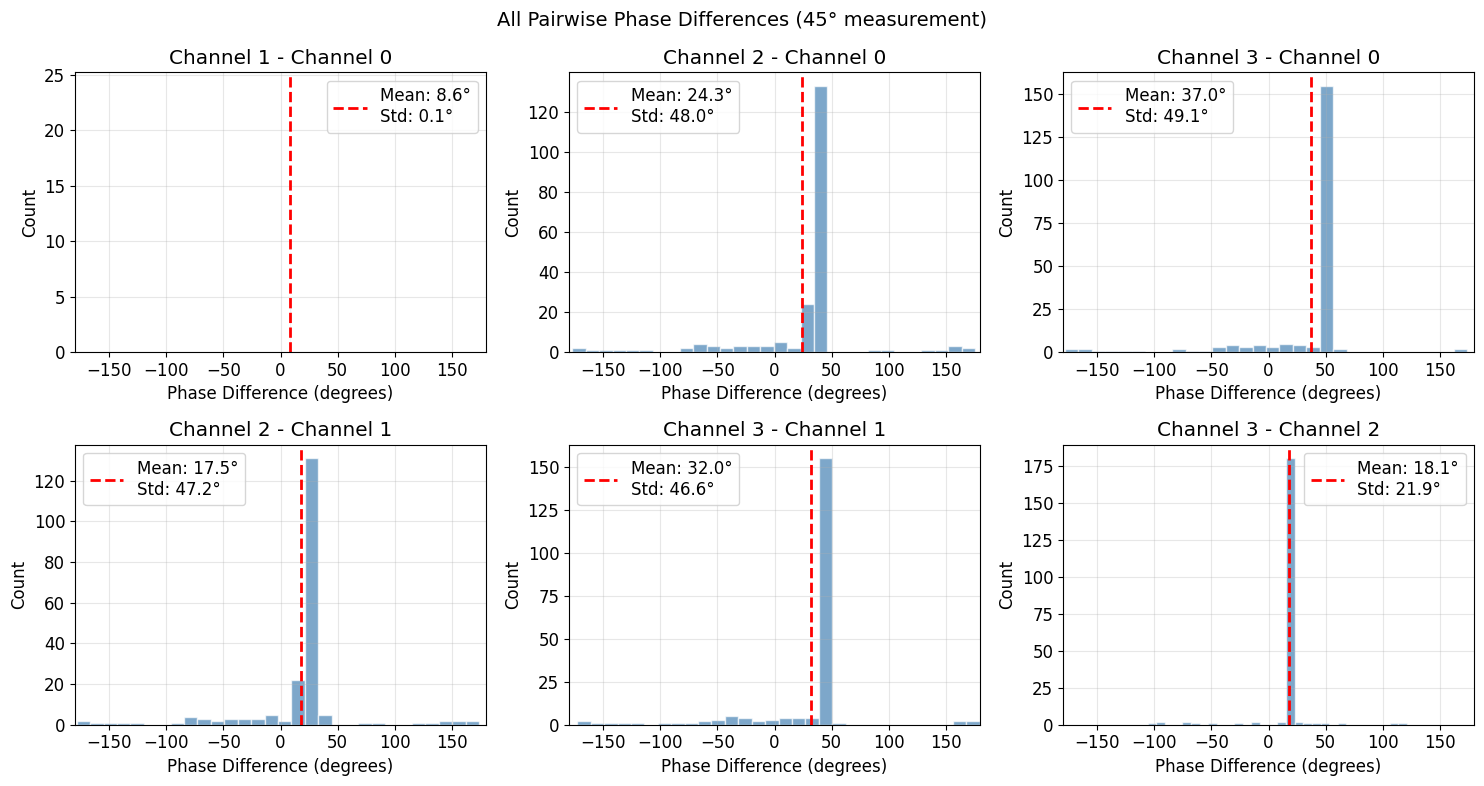

In [11]:
# Compute all pairwise phase differences for a single measurement
X = load_measurement(DATA_PATH, 45)
tone_phases, _ = extract_tone_phases(X, n_snapshots=200)

# All pairs
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, (ch_a, ch_b) in enumerate(pairs):
    diff = tone_phases[ch_b] - tone_phases[ch_a]
    diff = np.angle(np.exp(1j * diff))
    diff_deg = np.rad2deg(diff)
    
    ax = axes[idx]
    ax.hist(diff_deg, bins=30, edgecolor='white', alpha=0.7, color='steelblue')
    ax.axvline(np.mean(diff_deg), color='r', linestyle='--', linewidth=2,
               label=f'Mean: {np.mean(diff_deg):.1f}°\nStd: {np.std(diff_deg):.1f}°')
    ax.set_xlabel('Phase Difference (degrees)')
    ax.set_ylabel('Count')
    ax.set_title(f'Channel {ch_b} - Channel {ch_a}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-180, 180)

plt.suptitle('All Pairwise Phase Differences (45° measurement)', fontsize=14)
plt.tight_layout()
plt.show()

## 10. Phase Difference Matrix (Heatmap)

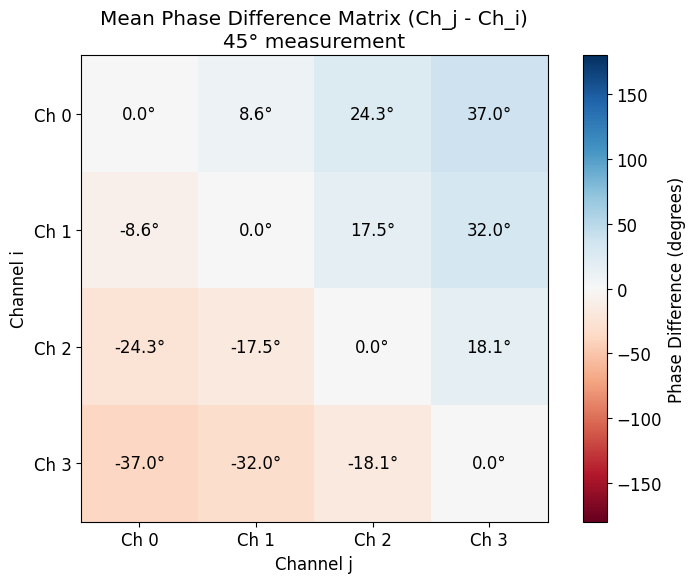

In [12]:
# Create phase difference matrix
n_channels = 4
phase_diff_matrix = np.zeros((n_channels, n_channels))

for i in range(n_channels):
    for j in range(n_channels):
        diff = tone_phases[j] - tone_phases[i]
        diff = np.angle(np.exp(1j * diff))
        phase_diff_matrix[i, j] = np.rad2deg(np.mean(diff))

plt.figure(figsize=(8, 6))
im = plt.imshow(phase_diff_matrix, cmap='RdBu', vmin=-180, vmax=180)
plt.colorbar(im, label='Phase Difference (degrees)')

# Add annotations
for i in range(n_channels):
    for j in range(n_channels):
        plt.text(j, i, f'{phase_diff_matrix[i, j]:.1f}°',
                 ha='center', va='center', fontsize=12,
                 color='white' if abs(phase_diff_matrix[i, j]) > 90 else 'black')

plt.xticks(range(4), [f'Ch {i}' for i in range(4)])
plt.yticks(range(4), [f'Ch {i}' for i in range(4)])
plt.xlabel('Channel j')
plt.ylabel('Channel i')
plt.title('Mean Phase Difference Matrix (Ch_j - Ch_i)\n45° measurement')
plt.tight_layout()
plt.show()

## 11. Phase Difference Evolution Over Time

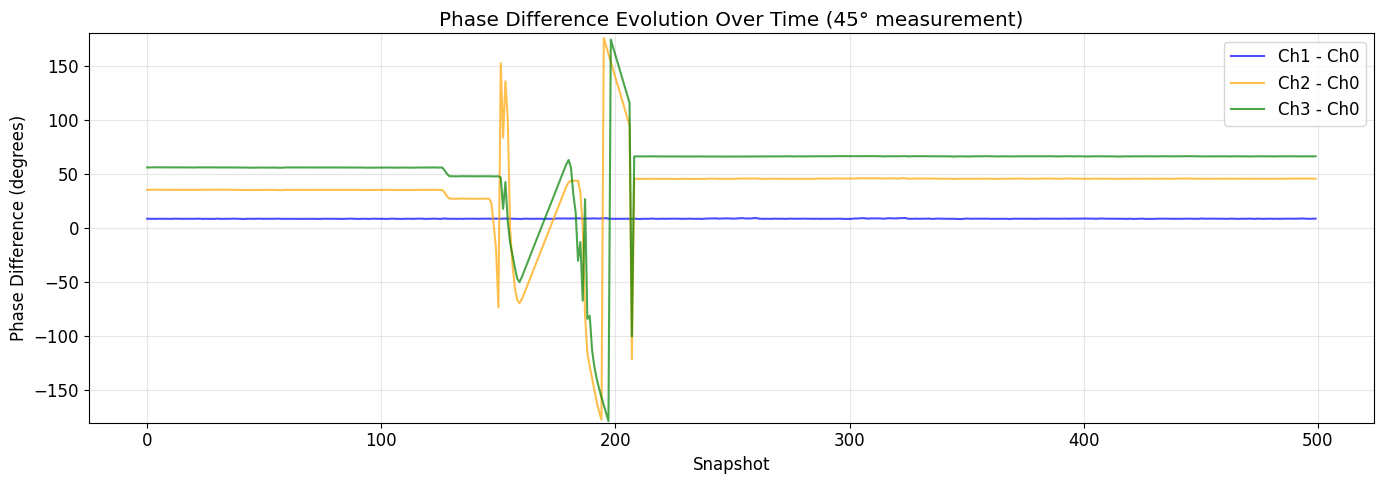

In [13]:
# Extract more snapshots to see time evolution
X = load_measurement(DATA_PATH, 45)
tone_phases_long, _ = extract_tone_phases(X, n_snapshots=500)

fig, ax = plt.subplots(figsize=(14, 5))

colors = ['blue', 'orange', 'green']
for ch in range(1, 4):
    diff = tone_phases_long[ch] - tone_phases_long[0]
    diff = np.angle(np.exp(1j * diff))
    ax.plot(np.rad2deg(diff), alpha=0.7, label=f'Ch{ch} - Ch0', color=colors[ch-1])

ax.set_xlabel('Snapshot')
ax.set_ylabel('Phase Difference (degrees)')
ax.set_title('Phase Difference Evolution Over Time (45° measurement)')
ax.set_ylim(-180, 180)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11b. Averaged Phase Differences (per 10k samples)

Averaging over larger windows to reduce noise and see underlying trends.

In [ ]:
def compute_averaged_phase_diff(X, window_size=10000, ref_channel=0):
    """
    Compute phase differences averaged over windows of samples.
    Uses circular mean to handle phase wrapping properly.
    """
    n_channels, n_samples = X.shape
    n_windows = n_samples // window_size
    
    avg_phase_diffs = {ch: [] for ch in range(n_channels)}
    
    for w in range(n_windows):
        start = w * window_size
        end = start + window_size
        segment = X[:, start:end]
        
        # Compute phase difference for each sample
        ref_phase = np.angle(segment[ref_channel])
        
        for ch in range(n_channels):
            if ch == ref_channel:
                avg_phase_diffs[ch].append(0)
            else:
                ch_phase = np.angle(segment[ch])
                # Phase difference
                diff = ch_phase - ref_phase
                # Circular mean: average the unit vectors, then take angle
                mean_diff = np.angle(np.mean(np.exp(1j * diff)))
                avg_phase_diffs[ch].append(mean_diff)
    
    return {ch: np.array(v) for ch, v in avg_phase_diffs.items()}, n_windows

# Compute averaged phase differences with 10k sample windows
X = load_measurement(DATA_PATH, 45)
WINDOW_SIZE = 10000

avg_pdiffs, n_windows = compute_averaged_phase_diff(X, window_size=WINDOW_SIZE)
print(f"Total samples: {X.shape[1]:,}")
print(f"Window size: {WINDOW_SIZE:,}")
print(f"Number of windows: {n_windows}")

In [ ]:
# Plot averaged phase differences
fig, ax = plt.subplots(figsize=(14, 6))

colors = ['blue', 'orange', 'green']
for ch in range(1, 4):
    ax.plot(avg_pdiffs[ch], '-', alpha=0.8, linewidth=1.5,
            label=f'phase difference 0-{ch}', color=colors[ch-1])

ax.set_xlabel('index (each = 10k samples)')
ax.set_ylabel('phase difference (rad)')
ax.set_title(f'Averaged phase differences (per {WINDOW_SIZE:,} samples) - 45° measurement')
ax.set_ylim(-np.pi, np.pi)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Statistics
print(f"\nAveraged Phase Difference Statistics (window = {WINDOW_SIZE:,} samples):")
print("-" * 60)
for ch in range(1, 4):
    data = avg_pdiffs[ch]
    print(f"  Ch0 - Ch{ch}:")
    print(f"    Mean: {np.mean(data):+.4f} rad ({np.rad2deg(np.mean(data)):+.2f}°)")
    print(f"    Std:  {np.std(data):.4f} rad ({np.rad2deg(np.std(data)):.2f}°)")
    print(f"    Range: [{np.min(data):.3f}, {np.max(data):.3f}] rad")

In [ ]:
# Compare different averaging window sizes
window_sizes = [1000, 10000, 50000, 100000]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, ws in enumerate(window_sizes):
    avg_pd, nw = compute_averaged_phase_diff(X, window_size=ws)
    
    ax = axes[idx]
    for ch in range(1, 4):
        ax.plot(avg_pd[ch], '-', alpha=0.8, linewidth=1, 
                label=f'0-{ch}', color=colors[ch-1])
    
    ax.set_xlabel(f'index (each = {ws:,} samples)')
    ax.set_ylabel('phase difference (rad)')
    ax.set_title(f'Window size: {ws:,} samples ({nw} windows)')
    ax.set_ylim(-np.pi, np.pi)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.suptitle('Phase Differences with Different Averaging Windows', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Analyze how std varies with window size
test_windows = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
std_vs_window = {ch: [] for ch in range(1, 4)}

for ws in test_windows:
    avg_pd, _ = compute_averaged_phase_diff(X, window_size=ws)
    for ch in range(1, 4):
        std_vs_window[ch].append(np.rad2deg(np.std(avg_pd[ch])))

fig, ax = plt.subplots(figsize=(10, 5))

for ch in range(1, 4):
    ax.plot(test_windows, std_vs_window[ch], 'o-', label=f'Ch 0-{ch}', color=colors[ch-1])

ax.set_xlabel('Window Size (samples)')
ax.set_ylabel('Std of Phase Difference (degrees)')
ax.set_title('Phase Noise vs Averaging Window Size')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nPhase noise (std) at different window sizes:")
print("-" * 50)
print(f"{'Window':<12} {'Ch 0-1':<12} {'Ch 0-2':<12} {'Ch 0-3':<12}")
print("-" * 50)
for i, ws in enumerate(test_windows):
    print(f"{ws:<12} {std_vs_window[1][i]:<12.2f} {std_vs_window[2][i]:<12.2f} {std_vs_window[3][i]:<12.2f}")

## 11c. Phase Jump Detection and Analysis

Detecting discrete phase jump events that could indicate sample drops or buffer issues.

In [ ]:
def detect_phase_jumps(phase_data, threshold_rad=0.5):
    """
    Detect sudden jumps in phase difference data.
    Returns indices and magnitudes of jumps.
    """
    # Compute derivative (change between consecutive windows)
    diff = np.diff(phase_data)
    # Handle wrapping: if jump > pi, it wrapped
    diff = np.angle(np.exp(1j * diff))
    
    # Find jumps exceeding threshold
    jump_indices = np.where(np.abs(diff) > threshold_rad)[0]
    jump_magnitudes = diff[jump_indices]
    
    return jump_indices, jump_magnitudes, diff

# Detect jumps in averaged data
WINDOW_SIZE = 10000
avg_pdiffs, n_windows = compute_averaged_phase_diff(X, window_size=WINDOW_SIZE)

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

print("=" * 60)
print("PHASE JUMP DETECTION")
print("=" * 60)

for idx, ch in enumerate([1, 2, 3]):
    jump_idx, jump_mag, derivative = detect_phase_jumps(avg_pdiffs[ch], threshold_rad=0.3)
    
    ax = axes[idx]
    
    # Plot phase difference
    ax.plot(avg_pdiffs[ch], '-', alpha=0.8, color=colors[idx], label=f'Phase diff 0-{ch}')
    
    # Mark jumps
    if len(jump_idx) > 0:
        ax.scatter(jump_idx, avg_pdiffs[ch][jump_idx], color='red', s=50, zorder=5,
                   label=f'{len(jump_idx)} jumps detected')
    
    ax.set_ylabel('Phase (rad)')
    ax.set_title(f'Channel 0-{ch}')
    ax.set_ylim(-np.pi, np.pi)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    print(f"\nCh 0-{ch}: {len(jump_idx)} phase jumps detected")
    if len(jump_idx) > 0:
        print(f"  Jump locations (window index): {jump_idx[:20].tolist()}{'...' if len(jump_idx) > 20 else ''}")
        print(f"  Jump magnitudes (rad): {[f'{m:.2f}' for m in jump_mag[:10]]}{'...' if len(jump_mag) > 10 else ''}")

axes[-1].set_xlabel(f'Window index (each = {WINDOW_SIZE:,} samples)')
plt.suptitle('Phase Jumps Detection (threshold = 0.3 rad)', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Check if jumps correlate between channels
jump_data = {}
for ch in [1, 2, 3]:
    jump_idx, jump_mag, _ = detect_phase_jumps(avg_pdiffs[ch], threshold_rad=0.3)
    jump_data[ch] = set(jump_idx)

# Find overlapping jumps
overlap_12 = jump_data[1] & jump_data[2]
overlap_13 = jump_data[1] & jump_data[3]
overlap_23 = jump_data[2] & jump_data[3]
overlap_all = jump_data[1] & jump_data[2] & jump_data[3]

print("\n" + "=" * 60)
print("JUMP CORRELATION ANALYSIS")
print("=" * 60)
print(f"\nJumps per channel:")
print(f"  Ch 0-1: {len(jump_data[1])} jumps")
print(f"  Ch 0-2: {len(jump_data[2])} jumps")
print(f"  Ch 0-3: {len(jump_data[3])} jumps")

print(f"\nOverlapping jumps (same window index):")
print(f"  Ch1 & Ch2: {len(overlap_12)} common jumps")
print(f"  Ch1 & Ch3: {len(overlap_13)} common jumps")
print(f"  Ch2 & Ch3: {len(overlap_23)} common jumps")
print(f"  All three: {len(overlap_all)} common jumps")

if len(overlap_23) > 0:
    print(f"\n  Common jump locations (Ch2 & Ch3): {sorted(list(overlap_23))[:20]}")

# Visualize jump timing correlation
fig, ax = plt.subplots(figsize=(14, 4))

for ch in [1, 2, 3]:
    jump_idx, _, _ = detect_phase_jumps(avg_pdiffs[ch], threshold_rad=0.3)
    y_pos = ch
    ax.scatter(jump_idx, [y_pos] * len(jump_idx), s=30, label=f'Ch 0-{ch}', alpha=0.7)

ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Ch 0-1', 'Ch 0-2', 'Ch 0-3'])
ax.set_xlabel(f'Window index (each = {WINDOW_SIZE:,} samples)')
ax.set_title('Phase Jump Timing Across Channels')
ax.grid(True, alpha=0.3, axis='x')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
# Analyze jump magnitude distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

print("\n" + "=" * 60)
print("JUMP MAGNITUDE ANALYSIS")
print("=" * 60)

for idx, ch in enumerate([1, 2, 3]):
    jump_idx, jump_mag, _ = detect_phase_jumps(avg_pdiffs[ch], threshold_rad=0.3)
    
    ax = axes[idx]
    if len(jump_mag) > 0:
        ax.hist(np.rad2deg(jump_mag), bins=30, edgecolor='white', alpha=0.7, color=colors[idx])
        ax.axvline(0, color='black', linestyle='-', alpha=0.3)
        
        # Mark common jump values
        for val in [-180, -90, 90, 180]:
            ax.axvline(val, color='red', linestyle='--', alpha=0.3)
    
    ax.set_xlabel('Jump Magnitude (degrees)')
    ax.set_ylabel('Count')
    ax.set_title(f'Ch 0-{ch} Jump Magnitudes')
    ax.grid(True, alpha=0.3)
    
    if len(jump_mag) > 0:
        print(f"\nCh 0-{ch}:")
        print(f"  Mean jump: {np.rad2deg(np.mean(jump_mag)):+.1f}°")
        print(f"  Std jump:  {np.rad2deg(np.std(jump_mag)):.1f}°")
        # Check for clustering near specific values
        near_pi = np.sum(np.abs(np.abs(jump_mag) - np.pi) < 0.3)
        near_half_pi = np.sum(np.abs(np.abs(jump_mag) - np.pi/2) < 0.3)
        print(f"  Jumps near ±π: {near_pi}")
        print(f"  Jumps near ±π/2: {near_half_pi}")

plt.suptitle('Distribution of Phase Jump Magnitudes', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Estimate sample drops based on phase jumps
# Phase per sample = 2π * (tone_freq / sample_rate)
# If we know the tone bin and FFT size, we can estimate this

# Find tone frequency as fraction of sample rate
fft_size = 8192
fft_result = fft(X[0, :fft_size])
tone_bin = np.argmax(np.abs(fft_result[1:fft_size//2])) + 1
tone_freq_normalized = tone_bin / fft_size  # As fraction of sample rate

phase_per_sample = 2 * np.pi * tone_freq_normalized

print("=" * 60)
print("SAMPLE DROP ESTIMATION")
print("=" * 60)
print(f"\nTone bin: {tone_bin} / {fft_size}")
print(f"Tone frequency: {tone_freq_normalized:.6f} × sample_rate")
print(f"Phase per sample: {phase_per_sample:.6f} rad ({np.rad2deg(phase_per_sample):.3f}°)")
print(f"\nSamples per full 2π rotation: {int(1/tone_freq_normalized)}")

# For each jump, estimate how many samples were dropped
print("\nEstimated sample drops per jump event:")
print("-" * 60)

for ch in [1, 2, 3]:
    jump_idx, jump_mag, _ = detect_phase_jumps(avg_pdiffs[ch], threshold_rad=0.3)
    
    if len(jump_mag) > 0:
        # Samples dropped = phase_jump / phase_per_sample
        samples_dropped = jump_mag / phase_per_sample
        
        print(f"\nCh 0-{ch}:")
        print(f"  Average samples dropped per jump: {np.mean(np.abs(samples_dropped)):.1f}")
        print(f"  Total estimated drops: {np.sum(np.abs(samples_dropped)):.0f}")
        
        # Show first few
        for i in range(min(5, len(jump_idx))):
            print(f"    Window {jump_idx[i]}: {jump_mag[i]:.3f} rad → ~{samples_dropped[i]:.1f} samples")

## 12. Summary Statistics

In [14]:
print("="*60)
print("PHASE DIFFERENCE SUMMARY (45° measurement)")
print("="*60)

print("\nPhase differences relative to Channel 0:")
print("-" * 40)
for ch in range(1, 4):
    diff = tone_phases_long[ch] - tone_phases_long[0]
    diff = np.angle(np.exp(1j * diff))
    diff_deg = np.rad2deg(diff)
    print(f"  Channel {ch} - Channel 0:")
    print(f"    Mean: {np.mean(diff_deg):+7.2f}°")
    print(f"    Std:  {np.std(diff_deg):7.2f}°")
    print(f"    Range: [{np.min(diff_deg):.1f}°, {np.max(diff_deg):.1f}°]")
    print()

print("\nAdjacent channel differences (for UCA):")
print("-" * 40)
for i in range(4):
    j = (i + 1) % 4
    diff = tone_phases_long[j] - tone_phases_long[i]
    diff = np.angle(np.exp(1j * diff))
    diff_deg = np.rad2deg(diff)
    print(f"  Channel {j} - Channel {i}: Mean = {np.mean(diff_deg):+7.2f}° (std = {np.std(diff_deg):.2f}°)")

print("="*60)

PHASE DIFFERENCE SUMMARY (45° measurement)

Phase differences relative to Channel 0:
----------------------------------------
  Channel 1 - Channel 0:
    Mean:   +8.61°
    Std:     0.15°
    Range: [8.3°, 9.3°]

  Channel 2 - Channel 0:
    Mean:  +37.77°
    Std:    34.25°
    Range: [-177.1°, 175.6°]

  Channel 3 - Channel 0:
    Mean:  +55.23°
    Std:    36.24°
    Range: [-178.5°, 174.2°]


Adjacent channel differences (for UCA):
----------------------------------------
  Channel 1 - Channel 0: Mean =   +8.61° (std = 0.15°)
  Channel 2 - Channel 1: Mean =  +29.88° (std = 33.50°)
  Channel 3 - Channel 2: Mean =  +19.62° (std = 13.90°)
  Channel 0 - Channel 3: Mean =  -55.23° (std = 36.24°)
